# What's cooking

Referências usadas aqui:

1. [machine-learning-articles/how-to-create-a-basic-mlp-classifier-with-the-keras-sequential-api.md at main · christianversloot/machine-learning-articles](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-basic-mlp-classifier-with-the-keras-sequential-api.md)

2. [sklearn.naive_bayes.MultinomialNB — scikit-learn 1.1.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

3. [1.9. Naive Bayes — scikit-learn 1.1.1 documentation](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)

4. [sklearn.neural_network.MLPClassifier — scikit-learn 1.1.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

5. [sklearn.svm.SVC — scikit-learn 1.1.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

Primeiramente, precisamos importar os dados para nossa área de trabalho, usando pandas:

In [2]:
train_df = pd.read_json('./train.json')
test_df = pd.read_json('./test.json')

train_df.sample(5)

,id,cuisine,ingredients
28285,17632,indian,"[tomatoes, flour, garlic, chopped cilantro, fr..."
5338,17601,french,"[frozen chopped spinach, shallots, salt, whole..."
28691,36409,mexican,"[eggs, all-purpose flour, unsalted butter, wat..."
23163,508,indian,"[ground ginger, tumeric, sunflower oil, frozen..."
33850,27261,mexican,"[stock, fresh cilantro, sea salt, tortilla chi..."


Tendo sido importados os dados, notamos que deseja-se prever a *cuisine* dada a lista de *ingredients*. Assim, para treinar modelos matemáticos baseados em **números** com propagação de gradiente para aprendizado, precisaremos transformar estes dados textuais em numéricos de alguma forma. 

# EDA and preprocessing

Vamos dar uma olhada em quantos ingredientes cada receita tem:

<AxesSubplot:xlabel='ingredients', ylabel='Count'>

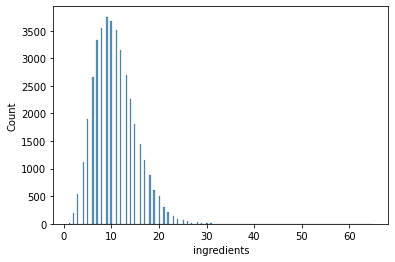

In [3]:
sns.histplot(train_df['ingredients'].str.len())

Visualmente, os dados aparentam possuir distribuição gaussiana de média próxima de 10, com um máximo próximo a 30 ingredientes e poucas receita possuem poucos ingredientes.

## Select features from Count Vectorizer

Uma maneira bastante empregada para tokenizar texto (mapear palavras ou grupos delas, sentenças ou até contextos para valores numéricos) com resultados frequentemente satisfatórios no contexto de NLP é o encoding com base em [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model). Isto é, suponha as frases:

```
"Eu sou Alexandre e gosto de IA"

"Alexandre estuda IA"
```

Elas podem ser mapeadas para:

```
[1 2 3 4 5 6]

[3 8 7]
```

de maneira que:

    1. = Eu
    2. = sou
    3. = Alexandre
    4. = e
    5. = gosto
    6. = de
    7. = IA
    8. = estuda

Este é um método de tokenizar frases. Outra maneira (que usaremos abaixo) é transformar cada frase em uma tabela com entradas binárias. Isto é, mapearemos as frases anteriores para uma tabela como esta:

```
    Eu  sou Alexandre   e   gosto   de  IA  estuda
1   1   1   1           1   1       1   1   0
2   0   0   1           0   0       0   1   1

```

Note que esse método faz com que percamos o sentido linear e semântico da sentença, mas isso não será um problema já que estamos lidando com uma sequência de ingredientes que podem ter sua ordem alterada (ou será que não?).

Vamos unir os ingredientes (atualmente palavras listadas em um arranjo) em uma única frase para cada receita:

In [4]:
# coletando ingredientes:
ingredients = train_df.ingredients.str.join(' ')
ingredients

0        romaine lettuce black olives grape tomatoes ga...
1        plain flour ground pepper salt tomatoes ground...
2        eggs pepper salt mayonaise cooking oil green c...
3                           water vegetable oil wheat salt
4        black pepper shallots cornflour cayenne pepper...
                               ...                        
39769    light brown sugar granulated sugar butter warm...
39770    KRAFT Zesty Italian Dressing purple onion broc...
39771    eggs citrus fruit raisins sourdough starter fl...
39772    boneless chicken skinless thigh minced garlic ...
39773    green chile jalapeno chilies onions ground bla...
Name: ingredients, Length: 39774, dtype: object

Agora que temos as frases que descrevem cada receita, e aplicaremos a elas uma remoção de palavras similares ou idênticas (extraíndo as raízes das palavras conjudadas), assim como pontuações e símbolos:

In [8]:
# removendo caracteres especiais, stemming e lemmatizing:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

def lemmatize_text(text):
    return [stemmer.stem(lemmatizer.lemmatize(w)) for w in word_tokenize(text)]

train = train_df.copy()
train['X'] = train_df.ingredients.str.join(' ')
train['X'].apply(lemmatize_text)

train.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,cuisine,ingredients,X
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...
3,22213,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...


Então, transformaremos estas frases em uma matriz binária de palavras conforme descrito anteriormente:

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
vectorized_ingredients = count_vectorizer.fit_transform(train.X)
print('20 features: '+ str(count_vectorizer.get_feature_names()[0:20]))
print('Total features: '+ str(len(count_vectorizer.get_feature_names())))
print(vectorized_ingredients.toarray()[0:10])

vectorized_ingredients_df = pd.DataFrame(columns = count_vectorizer.get_feature_names(), data = vectorized_ingredients.toarray())
vectorized_ingredients_df['num_ingr'] = vectorized_ingredients_df.sum(axis = 1)
vectorized_ingredients_df.head()

20 features: ['00', '10', '100', '14', '15', '25', '33', '40', '43', '95', '96', 'abalone', 'abbamele', 'absinthe', 'abura', 'acai', 'accent', 'accompaniment', 'achiote', 'acid']
Total features: 3010
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,00,10,100,14,15,25,33,40,43,95,...,zatarain,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini,épices,num_ingr
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33


Vejamos algumas estatísticas sobre estas palavras:

In [7]:
vectorized_ingredients_df.describe()

,00,10,100,14,15,25,33,40,43,95,...,zatarain,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini,épices,num_ingr
count,39774.000000,39774.000000,39774.000000,39774.000000,39774.000000,39774.000000,39774.000000,39774.000000,39774.000000,39774.000000,...,39774.000000,39774.000000,39774.000000,39774.000000,39774.000000,39774.000000,39774.000000,39774.000000,39774.000000,39774.000000
mean,0.000025,0.000126,0.000025,0.000126,0.000075,0.000075,0.000151,0.000302,0.000025,0.000101,...,0.000025,0.000025,0.000050,0.022452,0.000578,0.000277,0.000955,0.023407,0.000101,20.573214
std,0.005014,0.011211,0.005014,0.011211,0.008685,0.008685,0.012281,0.017367,0.005014,0.010028,...,0.005014,0.005014,0.007091,0.153975,0.024041,0.016628,0.030895,0.151859,0.010028,8.982429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,141.000000


Conforme visto no gráfico anterior e apresentado na coluna 'sum', muitas receitas (percentil de 75%) possuem 26 ou menos ingredientes. Similarmente, no percentil de 25% notamos de menos de 1/4 das receitas tem nuúmero de ingredientes igual ou menor a 14. 

Vejamos quanto cada palavra aparece em média:

In [8]:
vectorized_ingredients_df.mean()

00            0.000025
10            0.000126
100           0.000025
14            0.000126
15            0.000075
               ...    
zinfandel     0.000277
ziti          0.000955
zucchini      0.023407
épices        0.000101
num_ingr     20.573214
Length: 3011, dtype: float64

Notamos então que algumas palavras (ingredientes) aparecem com uma frequência maior do que outras, ou seja, aparecem mais vezes em diferentes receitas. Por exemplo zucchini aparecem em média muito mais do que épices.

Vamos então selecionar apenas as palavras que mais se relacionam com a saída. Para isso, primeiramente precisamos transformar as *cuisines* em números que representam a ordem em que cada cozinha aparece no banco de dados, representando numéricamente esta lista de palavras:

In [6]:
# encode (label) targets:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
cuisine = label_encoder.fit_transform(train_df['cuisine'].values)
cuisine

array([ 6, 16,  4, ...,  8,  3, 13])

Agora, finalmente, escolheremos as 1800 palavras mais relacionadas com as cozinhas a serem previstas, empregando a SelectKBest da biblioteca sklearn:

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
y = cuisine.copy()
X = vectorized_ingredients_df.values
num_selected = 1800
X_count_selected = SelectKBest(chi2, k=num_selected).fit_transform(X, y)
X_count_selected.shape

(39774, 1800)

Obs.: existem métodos mais sofisticados (no entanto eventualmente mais lentos) que podem resultar em performances melhores ou piores. Aqui utilizou-se a distribuição $\chi^2$ (chi2) para distinguir entre palavras que nos informam mais ou menos sobre a saída.

## Select features from Count Vectorizer

Discutimos anteriormente sobre como algumas palavras aparecem mais que outras. Uma forma de representar isso numericamente é através da vetorização TF-IDF (Term frequency * inverse document frequency). 

Este método consiste em calcular com qual frequência cada termo (ingrediente) aparece nos dados (TF). Em seguida, calcula-se em quantos documentos (receitas) estes termos aparecem (DF) e inverte-se algebricamente este valor ($\frac{1}{DF}$ = IDF).

Finalmente, multiplicando TF por IDF, obtemos TF-IDF, uma medida de quanto cada termo aparece no dados, normalizada pelo número de vezes em que esse termo apareceu nos registros que temos:

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorized_ingredients = tfidf_vectorizer.fit_transform(train.X)
print('20 features: '+ str(tfidf_vectorizer.get_feature_names()[0:20]))
print('Total features: '+ str(len(tfidf_vectorizer.get_feature_names())))
print(tfidf_vectorized_ingredients.toarray()[0:10])

tfidf_vectorized_ingredients_df = pd.DataFrame(columns = tfidf_vectorizer.get_feature_names(), data = tfidf_vectorized_ingredients.toarray())
tfidf_vectorized_ingredients_df['sum'] = tfidf_vectorized_ingredients_df.sum(axis = 1)
tfidf_vectorized_ingredients_df.head()


20 features: ['00', '10', '100', '14', '15', '25', '33', '40', '43', '95', '96', 'abalone', 'abbamele', 'absinthe', 'abura', 'acai', 'accent', 'accompaniment', 'achiote', 'acid']
Total features: 3010
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


,00,10,100,14,15,25,33,40,43,95,...,za,zatarain,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini,épices
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
y = cuisine.copy()
X = tfidf_vectorized_ingredients_df.values.copy()
X_tfidf_selected = SelectKBest(chi2, k=num_selected).fit_transform(X, y)
X_tfidf_selected.shape

(39774, 1800)

# Model training

In [10]:
# join data
y = cuisine.copy()
print(X_count_selected.shape)
print(X_tfidf_selected.shape)
X = np.concatenate((X_count_selected.copy(),X_tfidf_selected.copy()), axis=1)
X.shape

(39774, 1800)
(39774, 1800)


(39774, 3600)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)

(26648, 3600)
(26648,)


In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [14]:
import lightgbm as lgb

X_train2, X_eval, y_train2, y_eval = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

lgbmC = lgb.LGBMClassifier()    
lgbmC.fit(X_train2, y_train2,verbose=15,eval_set=(X_eval,y_eval))
y_pred = lgbmC.predict(X_test)
print('Accuracy: '+str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=train.cuisine.unique()))

[15]	valid_0's multi_logloss: 1.04829
[30]	valid_0's multi_logloss: 0.873528
[45]	valid_0's multi_logloss: 0.821136
[60]	valid_0's multi_logloss: 0.803141
[75]	valid_0's multi_logloss: 0.799371
[90]	valid_0's multi_logloss: 0.799319
Accuracy: 0.7754075879932958
              precision    recall  f1-score   support

       greek       0.85      0.49      0.62       164
 southern_us       0.61      0.41      0.49       271
    filipino       0.78      0.67      0.72       530
      indian       0.76      0.85      0.81       835
    jamaican       0.74      0.48      0.58       225
     spanish       0.59      0.60      0.59       911
     italian       0.78      0.66      0.71       382
     mexican       0.86      0.90      0.88       992
     chinese       0.68      0.46      0.55       222
     british       0.78      0.91      0.84      2581
        thai       0.94      0.60      0.73       150
  vietnamese       0.83      0.69      0.75       488
cajun_creole       0.85      0.66  

In [16]:
# import shap
# explainer = shap.TreeExplainer(lgbmC)
# shap_values = explainer.shap_values(X)
# num of predicted classes
# print(len(shap_values))
# shap values for 0th class for 0th row
# print(shap_values[0][0])

In [13]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(
    alpha = 1.0
)
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
print('Accuracy: '+str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=train.cuisine.unique()))

Accuracy: 0.7273350601858906
              precision    recall  f1-score   support

       greek       0.56      0.38      0.45       164
 southern_us       0.46      0.45      0.46       271
    filipino       0.57      0.75      0.65       530
      indian       0.71      0.87      0.78       835
    jamaican       0.70      0.44      0.54       225
     spanish       0.52      0.55      0.53       911
     italian       0.65      0.65      0.65       382
     mexican       0.84      0.86      0.85       992
     chinese       0.60      0.36      0.45       222
     british       0.84      0.79      0.82      2581
        thai       0.76      0.55      0.64       150
  vietnamese       0.87      0.60      0.71       488
cajun_creole       0.78      0.65      0.71       275
   brazilian       0.91      0.87      0.89      2138
      french       0.72      0.75      0.74       261
    japanese       0.55      0.36      0.44       155
       irish       0.58      0.71      0.64      142

In [18]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(random_state=1, 
    max_iter=150, #max_iter =300
    early_stopping=True,
    batch_size=int(np.round(X.shape[0]/10)),
    verbose=True,    
    learning_rate='adaptive'
    ).fit(X_train, y_train)
y_pred = mlpc.predict(X_test)
print('Accuracy: '+str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=train.cuisine.unique()))   

Iteration 1, loss = 2.86789207
Validation score: 0.326454
Iteration 2, loss = 2.48627808
Validation score: 0.397373
Iteration 3, loss = 2.24179429
Validation score: 0.487054
Iteration 4, loss = 2.02331284
Validation score: 0.538837
Iteration 5, loss = 1.82529459
Validation score: 0.577111
Iteration 6, loss = 1.64850713
Validation score: 0.606379
Iteration 7, loss = 1.49926813
Validation score: 0.636398
Iteration 8, loss = 1.37253205
Validation score: 0.665666
Iteration 9, loss = 1.26510933
Validation score: 0.690056
Iteration 10, loss = 1.17614633
Validation score: 0.702814
Iteration 11, loss = 1.10133928
Validation score: 0.716323
Iteration 12, loss = 1.04117884
Validation score: 0.723827
Iteration 13, loss = 0.98957992
Validation score: 0.729456
Iteration 14, loss = 0.94907938
Validation score: 0.739212
Iteration 15, loss = 0.91080115
Validation score: 0.747092
Iteration 16, loss = 0.87652594
Validation score: 0.741839
Iteration 17, loss = 0.84628517
Validation score: 0.749343
Iterat

In [19]:
y_pred = mlpc.predict(X_test)
print('Accuracy: '+str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=train.cuisine.unique()))   

Accuracy: 0.7834831631875666
              precision    recall  f1-score   support

       greek       0.78      0.55      0.65       164
 southern_us       0.61      0.54      0.57       271
    filipino       0.78      0.62      0.69       530
      indian       0.80      0.82      0.81       835
    jamaican       0.67      0.59      0.63       225
     spanish       0.64      0.62      0.63       911
     italian       0.78      0.71      0.74       382
     mexican       0.86      0.90      0.88       992
     chinese       0.65      0.49      0.56       222
     british       0.82      0.90      0.86      2581
        thai       0.77      0.69      0.73       150
  vietnamese       0.81      0.72      0.76       488
cajun_creole       0.78      0.74      0.76       275
   brazilian       0.91      0.92      0.91      2138
      french       0.84      0.76      0.80       261
    japanese       0.55      0.46      0.50       155
       irish       0.70      0.80      0.75      142

In [20]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(random_state=1, 
    # max_iter=150, #max_iter =300
    early_stopping=True,
    batch_size=int(np.round(X.shape[0]/10)),
    verbose=True,    
    activation='logistic',
    learning_rate='adaptive'
    ).fit(X_train, y_train)
y_pred = mlpc.predict(X_test)
print('Accuracy: '+str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=train.cuisine.unique()))   

Iteration 1, loss = 2.87647202
Validation score: 0.186492
Iteration 2, loss = 2.62049840
Validation score: 0.298687
Iteration 3, loss = 2.51174493
Validation score: 0.294934
Iteration 4, loss = 2.45510331
Validation score: 0.300188
Iteration 5, loss = 2.39843815
Validation score: 0.350094
Iteration 6, loss = 2.34101580
Validation score: 0.390994
Iteration 7, loss = 2.28118795
Validation score: 0.400375
Iteration 8, loss = 2.21865367
Validation score: 0.433021
Iteration 9, loss = 2.15541584
Validation score: 0.464916
Iteration 10, loss = 2.09138439
Validation score: 0.472420
Iteration 11, loss = 2.02751103
Validation score: 0.485178
Iteration 12, loss = 1.96381608
Validation score: 0.504315
Iteration 13, loss = 1.90133301
Validation score: 0.518199
Iteration 14, loss = 1.84070515
Validation score: 0.526829
Iteration 15, loss = 1.78233183
Validation score: 0.539212
Iteration 16, loss = 1.72692004
Validation score: 0.554221
Iteration 17, loss = 1.67347221
Validation score: 0.569231
Iterat

In [21]:
y_pred = mlpc.predict(X_test)
print('Accuracy: '+str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=train.cuisine.unique()))  

Accuracy: 0.7837879018741429
              precision    recall  f1-score   support

       greek       0.77      0.48      0.59       164
 southern_us       0.61      0.46      0.52       271
    filipino       0.76      0.66      0.71       530
      indian       0.79      0.84      0.81       835
    jamaican       0.70      0.55      0.61       225
     spanish       0.62      0.65      0.64       911
     italian       0.77      0.70      0.74       382
     mexican       0.87      0.90      0.89       992
     chinese       0.68      0.46      0.55       222
     british       0.81      0.89      0.85      2581
        thai       0.83      0.65      0.73       150
  vietnamese       0.81      0.72      0.76       488
cajun_creole       0.79      0.74      0.77       275
   brazilian       0.90      0.93      0.91      2138
      french       0.82      0.76      0.79       261
    japanese       0.61      0.45      0.52       155
       irish       0.70      0.80      0.74      142

In [30]:
import tensorflow as tf
# Imports
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



In [22]:
# Configuration options
feature_vector_length = X.shape[1]
num_classes = pd.unique(y).shape[0]


# Reshape the data - MLPs do not understand such things as '2D'.
# Reshape to 28 x 28 pixels = 784 features
X_train = X_train.reshape(X_train.shape[0], feature_vector_length)
X_test = X_test.reshape(X_test.shape[0], feature_vector_length)

# Convert into greyscale
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# X_train /= 255
# X_test /= 255

# Convert target classes to categorical ones
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

# Set the input shape
input_shape = (feature_vector_length,)
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(Dense(350, input_shape=input_shape, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(X_train, Y_train, epochs=10, batch_size=250, verbose=1, validation_split=0.2)
model.fit(X_train, Y_train, epochs=10*3, batch_size=int(np.round(X.shape[0]/10)), verbose=1, validation_split=0.2)

# Test the model after training
test_results = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

Feature shape: (3600,)
Epoch 1/30
6/6 [==============================] - 1s 153ms/step - loss: 2.8186 - accuracy: 0.1733 - val_loss: 2.5151 - val_accuracy: 0.3310
Epoch 2/30
6/6 [==============================] - 0s 72ms/step - loss: 2.3794 - accuracy: 0.3715 - val_loss: 2.1738 - val_accuracy: 0.4617
Epoch 3/30
6/6 [==============================] - 0s 70ms/step - loss: 2.0383 - accuracy: 0.5017 - val_loss: 1.8731 - val_accuracy: 0.5328
Epoch 4/30
6/6 [==============================] - 0s 71ms/step - loss: 1.7523 - accuracy: 0.5551 - val_loss: 1.6420 - val_accuracy: 0.5747
Epoch 5/30
6/6 [==============================] - 0s 75ms/step - loss: 1.5209 - accuracy: 0.6046 - val_loss: 1.4459 - val_accuracy: 0.6165
Epoch 6/30
6/6 [==============================] - 0s 78ms/step - loss: 1.3294 - accuracy: 0.6479 - val_loss: 1.2886 - val_accuracy: 0.6467
Epoch 7/30
6/6 [==============================] - 0s 83ms/step - loss: 1.1760 - accuracy: 0.6815 - val_loss: 1.1647 - val_accuracy: 0.6775
Epo

In [22]:
# from sklearn.svm import SVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# # svc = make_pipeline(StandardScaler(), SVC(gamma='auto', verbose = True, cache_size=7000))
# # svc = SVC(gamma='auto', verbose = True,cache_size=int(np.round(X.shape[0]/10)))
# svc = SVC(gamma='auto', verbose = True,cache_size=10)
# svc.fit(X_train, y_train)
# y_pred = svc.predict(X_test)
# print('Accuracy: '+str(accuracy_score(y_test, y_pred)))
# print(classification_report(y_test, y_pred, target_names=train.cuisine.unique()))

# Augmentation

In [ ]:
# WIP TBD

# Optimization (LGBM, Transformer, MLP)

In [ ]:
# WIP TBD